In [1]:
%load_ext autoreload
%autoreload 2

import gym

class CartPoleTask():
    """Task (environment) that defines the goal and provides feedback to the agent."""
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.action_repeat = 1

        self.state_size = self.action_repeat * self.env.observation_space.shape[0]
        self.action_low = 0
        self.action_high = 1
        self.action_size = 1

    def step(self, raw_action):
        """Uses action to obtain next state, reward, done."""
        
        # hack for converting action double -> int
        action = 1 if raw_action[0] >= 0.5 else 0
        
        total_reward = 0
        states = []
        for _ in range(self.action_repeat):
            state, reward, done, _ = self.env.step(action)
            total_reward += reward
            states.append(state)
        return np.concatenate(states), total_reward, done

    def reset(self):
        """Reset the sim to start a new episode."""
        state = self.env.reset()
        return np.concatenate([state] * self.action_repeat)

In [2]:
from agents.agent import DDPG_Agent
from collections import deque
import numpy as np
import sys

num_episodes = 500
max_step = 200
task = CartPoleTask()
agent = DDPG_Agent(task)

window_reward_size = 100
window_rewards = deque(maxlen=window_reward_size)
avg_rewards = []
best_avg_reward = 0

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode

    episode_reward = 0
    
    for _ in range(max_step):
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        
        if done:
            print("\rEpisode = {:4d}, Reward = {}, Best Average Reward = {}".format(i_episode, episode_reward, best_avg_reward), end="")
            window_rewards.append(episode_reward)
            break

    if(i_episode >= window_reward_size):
        avg_reward = np.mean(window_rewards)
        avg_rewards.append(avg_reward)
        
        if(len(avg_rewards) == 1):
            best_avg_reward = avg_reward
        elif(avg_reward > best_avg_reward):
            best_avg_reward = avg_reward

        
    sys.stdout.flush()

Using TensorFlow backend.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode =  500, Reward = 175.0, Best Average Reward = 83.59

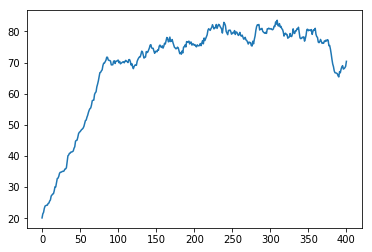

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot average reward
plt.plot(avg_rewards)

In [4]:
def renderAgent():
    state = env.reset()
    for t in range(1000):
        env.render()
        _, _, done, _ = env.step(env.action_space.sample())

        if done:
            break
